In [1]:
#In the begining, ther is time
import time

In [2]:
#Quality of life
#Some things we do generate a lot of warnings, and it just becomes clutter.
import warnings
warnings.filterwarnings("ignore")
#I like it when my notebook helps me out
%config IPCompleter.greedy=True
#Sometiems you just need to print pretty
from pprint import pprint
#Lots of these operations take many minutes to complete. So it behooves us to pickle the outputs and just unpickle them each time we re-open the notebook
import pickle


Data is from: https://www.kaggle.com/datasets/toygarr/datasets-for-natural-language-processing

Dataset is from a collection of sentiment datasets, but we just want to play with the food one for now.

"ctweet, stweet, food" datasets are positive or negative analysis (sentiment) -> 0 negative -> 1 positive (ctweet has neutral 0, 1, 2)

we're assuming that any code we write to deal with this food data set will be extensible later by simply adding the rest of the data if we so choose. At the moment it's simply faster to work with a smaller subset of the data as we design the pipeline and it's displays.

In [3]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import os

### Load in the dataset and do some basic confirmations

In [5]:
test = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone_3/data/food/test.csv')

In [6]:
test.shape

(145293, 2)

In [7]:
test.head()

,text,Y
0,this is the perfect blend of spice and sweet i...,1
1,the only coffee shop in town that carried big ...,1
2,this was a great price but amazon is not going...,1
3,while i love this product i feel disappointed ...,1
4,i have color treated hair and wanted to try th...,0


In [8]:
train = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone_3/data/food/train.csv')

In [9]:
train.shape

(217926, 2)

In [10]:
train.head()

,text,Y
0,i was put off at first by the green powder but...,1
1,these ginger chews are too good to be true i t...,1
2,i love salt and use a variety of salts to keep...,1
3,if asked to sum up this coffee pod drawer in o...,1
4,so far my dog has tried the chicken and peanut...,1


In [11]:
frames = [train, test]

### Combine the test/train sets as we're going to do our own splits later

In [12]:
df = pd.concat(frames)

In [13]:
df.shape

(363219, 2)

In [14]:
df.value_counts()

text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [15]:
stopwords = nltk.corpus.stopwords.words("english")

### Tokenize text

In [16]:
df['tokenized'] = df.text.apply(word_tokenize)



In [17]:
df.head(2)

,text,Y,tokenized
0,i was put off at first by the green powder but...,1,"[i, was, put, off, at, first, by, the, green, ..."
1,these ginger chews are too good to be true i t...,1,"[these, ginger, chews, are, too, good, to, be,..."


### Remove Stop Words


In [18]:
df['nostops'] = df.tokenized.apply(lambda  x: [item for item in x if item not in stopwords])

In [19]:
df.head(2)

,text,Y,tokenized,nostops
0,i was put off at first by the green powder but...,1,"[i, was, put, off, at, first, by, the, green, ...","[put, first, green, powder, bad, little, grain..."
1,these ginger chews are too good to be true i t...,1,"[these, ginger, chews, are, too, good, to, be,...","[ginger, chews, good, true, try, limit, one, d..."


### Stemming 
Might do lemmatization later, but stemming is simpler and more reliable and we're looking to get something working before we refine it. Lemmatization is a step we can experiment with in our refinement stages

We chose snowball because it's an older, and stable stemmer that incorporates improvements from the older stemmer algorithm Porter's real world experience
Snowball docs: https://www.nltk.org/api/nltk.stem.snowball.html
Article that informed our decision to choose Snowball: https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8


In [ ]:
stemmer = SnowballStemmer("english")
df['stemmed'] = df.nostops.apply(lambda x: [stemmer.stem(item) for item in x])

In [ ]:
df.head(1)

In [ ]:
df.stemmed.head(2)

### Bi-gram and n-gram manufacture

It looks as if stemming can increase recall, even in short texts but can also cause problems. We're going to move forward with stemmed words for now, but again can return to this if we seek optimization tasks down the line
Source: https://stackoverflow.com/questions/47219389/compute-word-n-grams-on-original-text-or-after-lemma-stemming-process#:~:text=Computing%20word%20n%2Dgrams%20after,you%20want%20to%20do%20it.

In [ ]:
df['bi_grams'] = df.stemmed.apply(lambda y: [x for x in ngrams(y, 2)])

In [ ]:
df.bi_grams.head(2)

In [ ]:
df['tri_grams'] = df.stemmed.apply(lambda y: [x for x in ngrams(y, 3)])

In [ ]:
df.tri_grams.head(2)

In [ ]:
bi_gram_counts

In [ ]:
bi_gram_counts.value_counts()

In [ ]:
bi_gram_list[0]

In [35]:
bi_corpus = [id2word.doc2bow(text) for text in bi_gram_list]


NameError: name 'id2word' is not defined

## Part of speach tagging
https://www.nltk.org/book/ch05.html

In [58]:
df['pos_tagged'] = df.tokenized.apply(nltk.pos_tag)

In [59]:
df['pos_tagged'].head()

0    [(i, NN), (was, VBD), (put, VBN), (off, RP), (...
1    [(these, DT), (ginger, JJR), (chews, NNS), (ar...
2    [(i, NN), (love, VBP), (salt, NN), (and, CC), ...
3    [(if, IN), (asked, VBN), (to, TO), (sum, VB), ...
4    [(so, RB), (far, RB), (my, PRP$), (dog, NN), (...
Name: pos_tagged, dtype: object

I did this kind of just to see what it would be like. It's not clear that this is going to be useful going forward.

## Vectorizing the corpus
#Creating a df for each degree of n-gram vector, for easy organization
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [28]:
#Vectorizer_Agent_mono = CountVectorizer(preprocessor=None, stop_words=stopwords)

In [29]:
#vectored_no_stops_mono = Vectorizer_Agent_mono.fit_transform(df.text.values) 

In [109]:
vectored_no_stops_mono = pickle.load(open("vectored_no_stops_mono", 'rb'))

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
type(vectored_no_stops_mono)

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scipy.sparse.csr.csr_matrix

In [108]:
#pickle.dump(vectored_no_stops_mono, open("vectored_no_stops_mono", 'wb'))

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Bigram Vector

In [31]:
#Vectorizer_Agent_bi = CountVectorizer(preprocessor=None, stop_words=stopwords, ngram_range=(1,2))

In [32]:
#vectored_no_stops_bi = Vectorizer_Agent_bi.fit_transform(df.text.values) 

In [106]:
vectored_no_stops_bi = pickle.load(open("vectored_no_stops_bi", 'rb'))

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
type(vectored_no_stops_bi)

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scipy.sparse.csr.csr_matrix

In [105]:
#pickle.dump(vectored_no_stops_bi, open("vectored_no_stops_bi", 'wb'))

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Trigram Vector

In [34]:
#Vectorizer_Agent_tri = CountVectorizer(preprocessor=None, stop_words=stopwords, ngram_range=(1,3))

In [35]:
#vectored_no_stops_tri = Vectorizer_Agent_tri.fit_transform(df.text.values) 

In [103]:
vectored_no_stops_tri = pickle.load(open("vectored_no_stops_tri", 'rb'))

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
type(vectored_no_stops_tri)

scipy.sparse.csr.csr_matrix

In [102]:
#pickle.dump(vectored_no_stops_tri, open("vectored_no_stops_tri", 'wb'))

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Word Clouds/bar charts
### divided by sentiment lables

Make giant strings for each set of words. Total, negative sentiment, and positive sentiment

In [37]:
start = time.time()
nostops_text_no_mods = " ".join(" ".join(listo) for listo in df.nostops)
stop = time.time()
print(str(stop-start))

17.10909652709961


In [38]:
nostops_text_pos = " ".join(" ".join(listo) for listo in df.nostops[df['Y'] == 1])

In [39]:
nostops_text_neg = " ".join(" ".join(listo) for listo in df.nostops[df['Y'] == 0])

In [40]:
def word_cloud_preprocessing(text):
    #I just love knowing how long my functions take to execute
    start = time.time()
    total_text_word_count = Counter(word_tokenize(text))
#     for stop in stopwords:
#         if stop in total_text_word_count.keys():
#             del total_text_word_count[stop]
    count_dict = dict(total_text_word_count, index=(len(total_text_word_count)))
    series_for_heads = pd.Series(count_dict)
    x = series_for_heads.sort_values(ascending=False).head(15).index
    y = series_for_heads.sort_values(ascending=False).head(15)
    stop = time.time()
    print(str(stop-start))
    #build the actual wordcloud boject
    total_wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="black",
                               width=400,
                                height=400,
                                relative_scaling=1,
                                colormap='winter',
                                collocations=False,
                                stopwords=stopwords,
                                scale=2
                            
                               ).generate(text)
    stop = time.time()
    print(str(stop-start))
    return x, y, total_wordcloud

In [41]:
def word_cloud(x, y, wordcloud):
    # Display the generated image:
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #testing setting figsize on subfigure directly, rather than at this higher level
    #sns.set(rc = {'figure.figsize':(40,5)})
    
    axes[0].set_title('Top Word counts')
    sns.barplot(x, y, ax=axes[0], palette="winter")
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title('Word Cloud')
    plt.show()

In [42]:
def bar_and_cloud_generator(text):
    bar_x, bar_y, cloud_object = word_cloud_preprocessing(text)
    word_cloud(bar_x, bar_y, cloud_object)

## All words

58.66602849960327
79.40503120422363


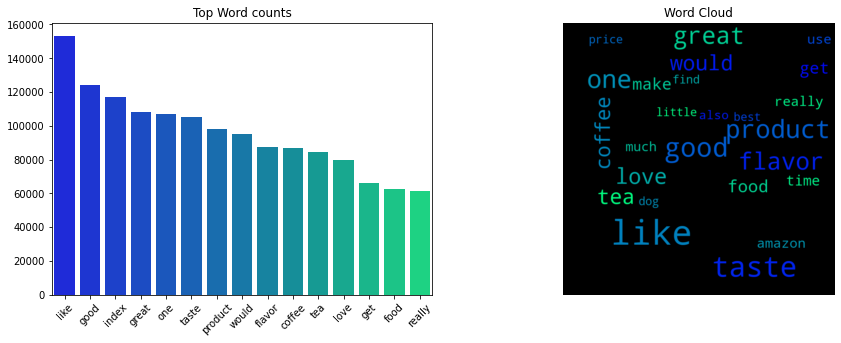

In [43]:
bar_and_cloud_generator(nostops_text_no_mods)

# Words from sentances labeled positive

All the way to product this is consistent to the total word count

44.198267698287964
58.66326427459717


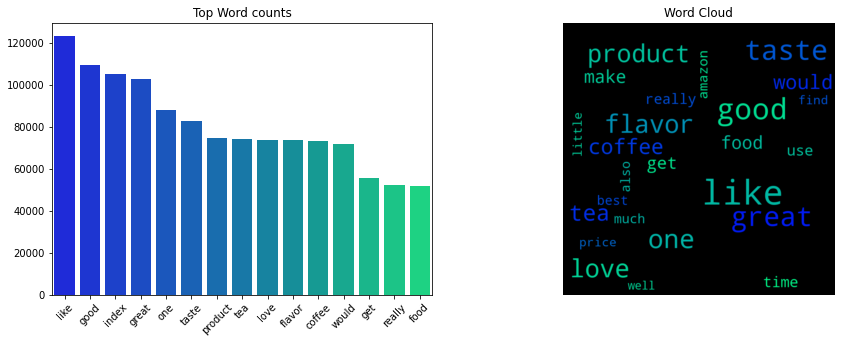

In [44]:
bar_and_cloud_generator(nostops_text_pos)

# Words from sentances labeled negative

9.590013265609741
12.941675186157227


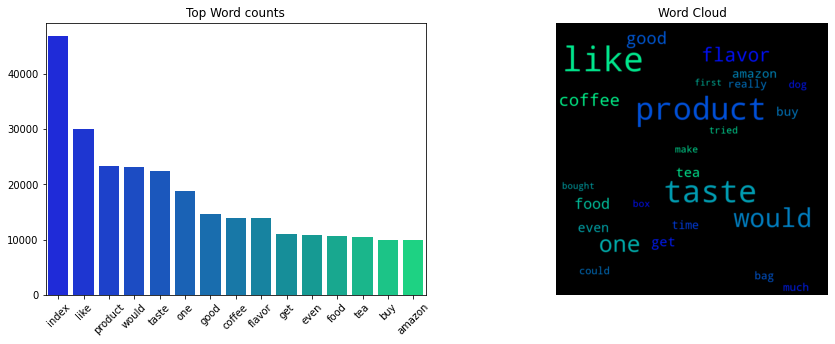

In [45]:
bar_and_cloud_generator(nostops_text_neg)

We can see there's considerable overlap between all three ways of organizing our corpus.

## Clustering and Secondary EDA

We played briefly with using DBSCAN, but it didn't converge at all, it gave us 360k categories

Thinking that instead of conventional clustering we're going to play with latent dirichlet allocation because it'll do a similar thing as K-means, but also provide us with a lot more information about the composition of those clusters.
Original Paper: https://ai.stanford.edu/~ang/papers/nips01-lda.pdf
Tutorial we used to help us get going: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
Docs for the gensim module we're sdoing the lda with: https://radimrehurek.com/gensim/models/ldamodel.html

In [30]:
#Tools for lDA visualization

#Normally I like to my imports at the top of a ntoebook, but these imports make the
#notebook spam an annoying warning that I can only fix by downgrading some stuff, which I am disinclined to do.
import pyLDAvis.gensim_models 
import pickle 
import pyLDAvis

In [77]:
stemmed_texts = list(df.stemmed)

In [78]:
#makes a dictionary mapping to unique IDs
id2word = Dictionary(stemmed_texts)


In [80]:
#makes a bag of words version of the Gensim Dictionary
corpus = [id2word.doc2bow(text) for text in stemmed_texts]


In [81]:
# Train the model on the corpus.
num_topics = 10
lda = LdaModel(corpus,  id2word=id2word, num_topics=num_topics)

In [94]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 0:
    LDAvis_prepared = pyLDAvis.gensim_models .prepare(lda, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.034156  0.102538       1        1  18.701455
0      0.001260  0.153829       2        1  12.499609
3      0.082462  0.050674       3        1  12.429818
6      0.060895  0.009963       4        1  12.205238
5      0.070216 -0.038195       5        1  11.090821
1      0.106242 -0.016197       6        1   8.957325
9      0.054929 -0.112165       7        1   8.059191
8     -0.210783  0.118824       8        1   6.103188
4      0.156146 -0.097449       9        1   5.076460
7     -0.287210 -0.171823      10        1   4.876894, topic_info=        Term          Freq          Total Category  logprob  loglift
492      tea  99003.000000   99003.000000  Default  30.0000  30.0000
149    coffe  93715.000000   93715.000000  Default  29.0000  29.0000
289     food  79496.000000   79496.000000  Default  28.0000  28.0000
203      dog  51436.000000   51436.000000  Default  27.0000  27.0000
371   amazon  60278.000000   60278.000000  Default  26.0000  26.0000
...      ...           ...            ...      ...      ...      ...
21     natur   3431.434983   22783.524441  Topic10  -5.2791   1.1276
1423   pasta   2956.803355   11966.995868  Topic10  -5.4280   1.6226
36       use   3475.458061  120604.910709  Topic10  -5.2664  -0.5261
735     look   3116.293078   40026.729117  Topic10  -5.3754   0.4678
743   packag   2954.797903   36570.060921  Topic10  -5.4287   0.5049

[736 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
665       3  0.040569      add
665       4  0.137652      add
665       5  0.456680      add
665       6  0.026131      add
665       7  0.289021      add
...     ...       ...      ...
5308      9  0.999183     yogi
698       3  0.275255   yogurt
698       7  0.724453   yogurt
3821      8  0.998955  younger
6037      6  0.999380     zico

[1960 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 7, 6, 2, 10, 9, 5, 8])

This is pretty neat, but honestly I don't care very much. These distributions don't really affect what I'm about to do. I was just curious to try this.

We might do something similar to the earlier word clouds and break this up by sentiment. SEe if the clusters are significantly different across sentiments, but again it's not deeply relevant to our long term goals, so we may not take the time